# HW2: Pedro Armengol

# 1) Import Packages and Read CSV

In [6]:
from __future__ import division
import matplotlib.pyplot as plt
import plotly.plotly as py  
import pandas as pd
import numpy as np
from sklearn import preprocessing, cross_validation, svm, metrics, tree, decomposition, svm
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier, OrthogonalMatchingPursuit, RandomizedLogisticRegression
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import ParameterGrid
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
import random
import pylab as pl
import matplotlib.pyplot as plt
from scipy import optimize
import time
import seaborn as sns

%matplotlib inline

path = "/Users/Usuario/Documents/Chicago/CS_ML/HW2/Data/"
data = "credit-data.csv"

/Users/Usuario/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.

/Users/Usuario/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.



In [13]:
credit_df = pd.read_csv(path+data)

## 2) DESCRIPTIVE STATISTICS

In [5]:
list(credit_df)
credit_df.count()

PersonID                                150000
SeriousDlqin2yrs                        150000
RevolvingUtilizationOfUnsecuredLines    150000
age                                     150000
zipcode                                 150000
NumberOfTime30-59DaysPastDueNotWorse    150000
DebtRatio                               150000
MonthlyIncome                           120269
NumberOfOpenCreditLinesAndLoans         150000
NumberOfTimes90DaysLate                 150000
NumberRealEstateLoansOrLines            150000
NumberOfTime60-89DaysPastDueNotWorse    150000
NumberOfDependents                      146076
dtype: int64

The database have 150,000 observations, where every observation is a creditholder. Some variables have missing values: NA (for example, MonthlyIncome has almost 3,000 NA's). There would be neccesary a data imputation mechanism in order to build a balace dataframe for the predictions.

## Table of Means


In [6]:
table_means = credit_df.groupby(["SeriousDlqin2yrs"])["RevolvingUtilizationOfUnsecuredLines","age","DebtRatio","MonthlyIncome","NumberOfOpenCreditLinesAndLoans","NumberOfDependents"].mean()
table_means

,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfDependents
SeriousDlqin2yrs,,,,,,
0,6.168855,52.751375,357.151168,6747.837774,8.493620,0.743417
1,4.367282,45.926591,295.121066,5630.826493,7.882306,0.948208


In this table, we show the difference in means between the people that experienced financial distress (Serious Dlqin2yrs == 1) and the ones that not. In general, the people that experienced financial distress have relatively less revolving utilization of unsecured lines. The same group is relatively younger, have a smaller debt ration (that is reasonable given less access to loans) and, also, a smaller monthly income. In the same direction, the number of open credits of the "financial distress" group is smaller and the other group. The number of dependants is higher in the "financial distress" group as well. 

## Correlation Matrix

In [7]:
credit_df.corr()

,PersonID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
PersonID,1.000000,0.002801,0.002372,0.004403,-0.002721,-0.000571,-0.002906,0.002632,0.004586,-0.001104,-0.000666,-0.000777,-0.000055
SeriousDlqin2yrs,0.002801,1.000000,-0.001802,-0.115386,0.005103,0.125587,-0.007602,-0.019746,-0.029669,0.117175,-0.007038,0.102261,0.046048
RevolvingUtilizationOfUnsecuredLines,0.002372,-0.001802,1.000000,-0.005898,-0.003571,-0.001314,0.003961,0.007124,-0.011281,-0.001061,0.006235,-0.001048,0.001557
age,0.004403,-0.115386,-0.005898,1.000000,0.002590,-0.062995,0.024188,0.037717,0.147705,-0.061005,0.033150,-0.057159,-0.213303
zipcode,-0.002721,0.005103,-0.003571,0.002590,1.000000,0.007429,0.001458,0.002070,-0.003609,0.007543,-0.001345,0.007619,-0.003511
NumberOfTime30-59DaysPastDueNotWorse,-0.000571,0.125587,-0.001314,-0.062995,0.007429,1.000000,-0.006542,-0.010217,-0.055312,0.983603,-0.030565,0.987005,-0.002680
DebtRatio,-0.002906,-0.007602,0.003961,0.024188,0.001458,-0.006542,1.000000,-0.028712,0.049565,-0.008320,0.120046,-0.007533,-0.040673
MonthlyIncome,0.002632,-0.019746,0.007124,0.037717,0.002070,-0.010217,-0.028712,1.000000,0.091455,-0.012743,0.124959,-0.011116,0.062647
NumberOfOpenCreditLinesAndLoans,0.004586,-0.029669,-0.011281,0.147705,-0.003609,-0.055312,0.049565,0.091455,1.000000,-0.079984,0.433959,-0.071077,0.065322
NumberOfTimes90DaysLate,-0.001104,0.117175,-0.001061,-0.061005,0.007543,0.983603,-0.008320,-0.012743,-0.079984,1.000000,-0.045205,0.992796,-0.010176


After running a correlation matrix, is easy to see that there are not strong correlations (negative nor positive) between our variable of interest (SeriousDlqin2yr) under the standar of $p > .6$. However, given that SeriousDlqin2yr is a dummy, some correlations are worth to note: first there is a negative correlation between age and propensity to suffer "financial distress". Second, there is a positive correlation between financial distress and NumberOfTime60-89DaysPastDueNotWorse, NumberOfTimes90DaysLate and NumberOfTime60-89DaysPastDueNotWorse. In other words, sort term loans debt payment delays are positively associated to long term (2 years) financial distress.




### Distributions of Key Variables

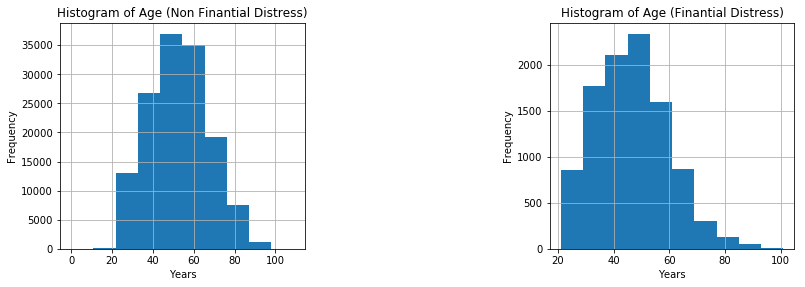

In [144]:
# histogram of age distribution grouped by financial distress
plt.figure(1)

plt.subplot(221)
plt.title('Histogram of Age (Non Finantial Distress)')
credit_df.age[credit_df["SeriousDlqin2yrs"] == 0].hist()
plt.xlabel('Years')
plt.ylabel('Frequency')

plt.subplot(222)
plt.title('Histogram of Age (Finantial Distress)')
credit_df.age[credit_df["SeriousDlqin2yrs"] == 1].hist()
plt.xlabel('Years')
plt.ylabel('Frequency')

plt.subplots_adjust(top=4, bottom=0.08, left=0.30, right=2.0, hspace=3.0,wspace=1.0)
plt.show()




The age distribution of the people with "financial distress" is relatively more positively skewed that the people without it. In other words, the biggest chunk of people with "financial distress" is concentrated in early ages,  with a relative small incidence of cases beyond the $60$ years old.

In [146]:
credit_df["monthly_categ"] = pd.qcut(credit_df["MonthlyIncome"], 5, labels=["Very Low","Low","Middle","Middle High","Very High"])

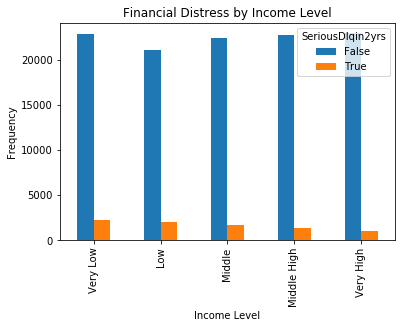

In [150]:
# Barplot of Income Level and Number of Dependants grouped by Financial Distress (True or False)

pd.crosstab(credit_df.monthly_categ, credit_df.SeriousDlqin2yrs.astype(bool)).plot(kind='bar')
plt.title('Financial Distress by Income Level')
plt.xlabel('Income Level')
plt.ylabel('Frequency')

plt.show()


In the previous graph, there can be observe an slighly trend to suffer less financial distress with higher income levels. 

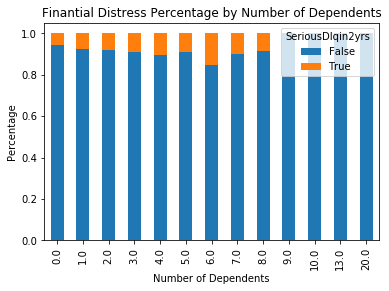

In [155]:
distress_dependents = pd.crosstab(credit_df.NumberOfDependents, credit_df.SeriousDlqin2yrs.astype(bool))
distress_dependents.div(distress_dependents.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Finantial Distress Percentage by Number of Dependents')
plt.xlabel('Number of Dependents')
plt.ylabel('Percentage')

The relationship between number of dependents and a higher percentage of finantial distress is not completly clear. However, there can be observe an increasing trend in the proportion of people with financial distress with the increment of the number of dependents in the range between 0 and 7 (the vast mayority of the sample).

## 3) Pre - Process Data

In [7]:
#Read again the dataframe
df = pd.read_csv(path+data)

In [8]:

def filling_missing(df):
    '''
    Receive a data frame with missing values and return a data frame without missing values
    Input:s
        Data frame with Nan's
    Output:
        Data frame without Nan's
    
    '''
    
    df = df.fillna(df.mean())
    
    return df
    

In [9]:
df = filling_missing(df)



## 4) Generate Features/Predictors

In [10]:
def categorize_continuos(var,bins,df):

    '''
    Receive a continuos variable and discretaize it. After, the variable is merge with the database of interest.
    Input:
        var: string (variable name)
        bins: int (number of cuts in the variable)
        df: dataframe (where the continuos variable is located and where the discrete variable will be merge)
    Output:
        df: dataframe (with the categorical variable)
    
    '''
    df["{0}_categ".format(var)] = pd.cut(df[var],bins)
    
    return df

def categorical_dummy(var,df):

    '''
    Receive a categorical variable and convert it into several dummies (one for each category). After, the dummies are merge 
    with the databse of interest
    Input:
        variable: Data frame column (categorical variable)
        df: dataframe      
    Output:
        df: dataframe (with the dummy variables)
        
    '''
    dummies = pd.get_dummies(df[var])
    
    n = 0
    for i in dummies:
        n += 1
        name = "dummy{0}{1}".format(var,n)
        dummies = dummies.rename(columns = {i:name})
    
    df = df.merge(dummies, left_index = True, right_index = True)   
    
    return df




### Processing Data before classification




In [11]:
list_cov = ["NumberOfTime30-59DaysPastDueNotWorse", "NumberOfTimes90DaysLate","NumberOfTime60-89DaysPastDueNotWorse"]

We will build the model just with the 4 variables that have the higher correlation coeficient (in absolute value) with our variable to predict (SeriousDlqin2yrs).

In [12]:
list_cov

['NumberOfTime30-59DaysPastDueNotWorse',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse']

##### This loop will create categorical variables for the covariates on the previous list and dummies for each categorie, then will refresh the data frame with the new predictors.


In [13]:
for i in list_cov:
    df = categorize_continuos(i,10,df)
    df = categorical_dummy(i, df)


### Delimit X and Y

In [14]:
list_covariates = []
for i in df:
    if "dummy" in i or i == "age":
        list_covariates.append(i)
        
y = df["SeriousDlqin2yrs"]

X = df[list_covariates]



## 5) Classifiers Estimation (The following code is taken from the Rayid's Ghani Magic Loop)


### Define combinations of models and parameters

In [16]:
def define_clfs_params():

    clfs = {'RF': RandomForestClassifier(n_estimators=50, n_jobs=-1),
        'AB': AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=200),
        'LR': LogisticRegression(penalty='l1', C=1e5),
        'SVM': svm.SVC(kernel='linear', probability=True, random_state=0),
        'GB': GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=10),
        'DT': DecisionTreeClassifier(),
        'KNN': KNeighborsClassifier(n_neighbors=3) 
            }

    grid = { 
    'RF':{'n_estimators': [10,100], 'max_depth': [5,50], 'max_features': ['sqrt','log2'],'min_samples_split': [2,10]},
    'LR': { 'penalty': ['l1','l2'], 'C': [0.00001,0.001,0.1,1,10]},
    'AB': { 'algorithm': ['SAMME', 'SAMME.R'], 'n_estimators': [1,10,100,1000,10000]},
    'GB': {'n_estimators': [10,100], 'learning_rate' : [0.001,0.1,0.5],'subsample' : [0.1,0.5,1.0], 'max_depth': [5,50]},
    'DT': {'criterion': ['gini', 'entropy'], 'max_depth': [1,5,10,20,50,100], 'max_features': ['sqrt','log2'],'min_samples_split': [2,5,10]},
    'SVM' :{'C' :[0.00001,0.0001,0.001,0.01,0.1,1,10],'kernel':['linear']},
    'KNN' :{'n_neighbors': [1,5,10,25,50,100],'weights': ['uniform','distance'],'algorithm': ['auto','ball_tree','kd_tree']}
           }
    
    
    return clfs, grid
    

### Define functions of efficiency evaluation (precision and recall)

In [17]:
def generate_binary_at_k(y_scores, k):
    print("generate_binary_at_k")
    print(len(y_scores))
    print(k)   
    cutoff_index = int(len(y_scores) * (k / 100.0))
    print("cutoff_index")
    print(cutoff_index)
    test_predictions_binary = [1 if x < cutoff_index else 0 for x in range(len(y_scores))]
    return test_predictions_binary

def precision_at_k(y_true, y_scores, k):
    preds_at_k = generate_binary_at_k(y_scores, k)
    #precision, _, _, _ = metrics.precision_recall_fscore_support(y_true, preds_at_k)
    #precision = precision[1]  # only interested in precision for label 1
    precision = precision_score(y_true, preds_at_k)
    return precision

def plot_precision_recall_n(y_true, y_prob, model_name):
    from sklearn.metrics import precision_recall_curve
    y_score = y_prob
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_score)
    precision_curve = precision_curve[:-1]
    recall_curve = recall_curve[:-1]
    pct_above_per_thresh = []
    number_scored = len(y_score)
    for value in pr_thresholds:
        num_above_thresh = len(y_score[y_score>=value])
        pct_above_thresh = num_above_thresh / float(number_scored)
        pct_above_per_thresh.append(pct_above_thresh)
    pct_above_per_thresh = np.array(pct_above_per_thresh)
    
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.plot(pct_above_per_thresh, precision_curve, 'b')
    ax1.set_xlabel('percent of population')
    ax1.set_ylabel('precision', color='b')
    ax2 = ax1.twinx()
    ax2.plot(pct_above_per_thresh, recall_curve, 'r')
    ax2.set_ylabel('recall', color='r')
    ax1.set_ylim([0,1])
    ax1.set_ylim([0,1])
    ax2.set_xlim([0,1])
    
    name = model_name
    plt.title(name)
    #plt.savefig(name)
    plt.show()

### Define Loop of classifiers

In [18]:
def clf_loop(models_to_run, clfs, grid, X, y):
    results_df =  pd.DataFrame(columns=('model_type','clf', 'parameters', 'auc-roc','p_at_5', 'p_at_10', 'p_at_20'))
    for n in range(1, 2):
        # create training and valdation sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
        for index,clf in enumerate([clfs[x] for x in models_to_run]):
            print("clf")
            print(clf)
            parameter_values = grid[models_to_run[index]]
            for p in ParameterGrid(parameter_values):
                print("parameters")
                print(p)
                clf.set_params(**p)
                y_pred_probs = clf.fit(X_train, y_train).predict_proba(X_test)[:,1]
                # you can also store the model, feature importances, and prediction scores
                # we're only storing the metrics for now
                y_pred_probs_sorted, y_test_sorted = zip(*sorted(zip(y_pred_probs, y_test), reverse=True))
                results_df.loc[len(results_df)] = [models_to_run[index],clf, p,
                                                    roc_auc_score(y_test, y_pred_probs),
                                                    precision_at_k(y_test_sorted,y_pred_probs_sorted,5.0),
                                                    precision_at_k(y_test_sorted,y_pred_probs_sorted,10.0),
                                                    precision_at_k(y_test_sorted,y_pred_probs_sorted,20.0)]
                
                plot_precision_recall_n(y_test,y_pred_probs,clf)
         
    return results_df

### The estimation

We will run the classification models with $SeriousDlqin2yrs$ as the depedent variables and the dummies of the section "Processing Data before classification" as indepent variables.

Is important to recall, that the other variables $MonthlyIncome$, $NumberOfDependents$, $DebtRatio$, and so on where added to the model without accuracy gains (see next section).

In [19]:
def results(X,y):

    clfs, grid = define_clfs_params()
    models_to_run=['RF','AB','LR', 'SVM', 'GB', 'DT','KNN']  
    results_df = clf_loop(models_to_run, clfs,grid, X,y)
    return results_df

clf
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
parameters
{'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 10}
generate_binary_at_k
37500
5.0
cutoff_index
1875
generate_binary_at_k
37500
10.0
cutoff_index
3750
generate_binary_at_k
37500
20.0
cutoff_index
7500


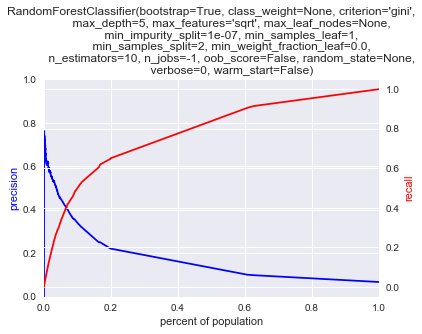

parameters
{'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}
generate_binary_at_k
37500
5.0
cutoff_index
1875
generate_binary_at_k
37500
10.0
cutoff_index
3750
generate_binary_at_k
37500
20.0
cutoff_index
7500


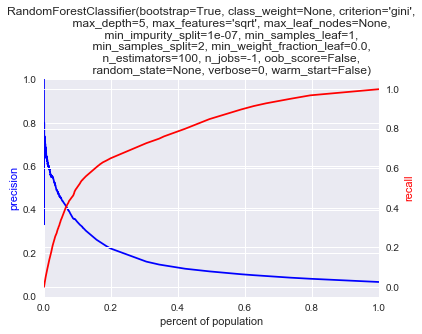

parameters
{'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 10}
generate_binary_at_k
37500
5.0
cutoff_index
1875
generate_binary_at_k
37500
10.0
cutoff_index
3750
generate_binary_at_k
37500
20.0
cutoff_index
7500


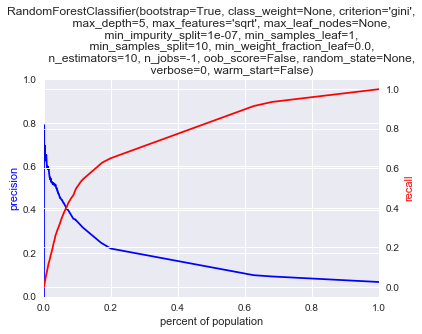

parameters
{'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100}
generate_binary_at_k
37500
5.0
cutoff_index
1875
generate_binary_at_k
37500
10.0
cutoff_index
3750
generate_binary_at_k
37500
20.0
cutoff_index
7500


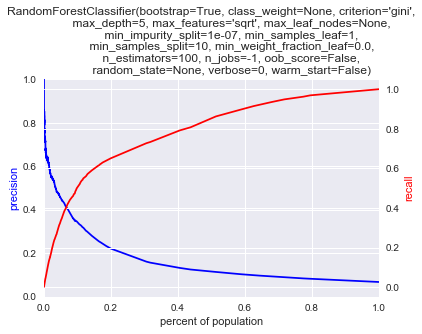

parameters
{'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 10}
generate_binary_at_k
37500
5.0
cutoff_index
1875
generate_binary_at_k
37500
10.0
cutoff_index
3750
generate_binary_at_k
37500
20.0
cutoff_index
7500


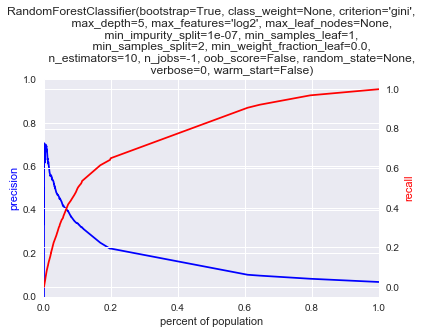

parameters
{'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100}
generate_binary_at_k
37500
5.0
cutoff_index
1875
generate_binary_at_k
37500
10.0
cutoff_index
3750
generate_binary_at_k
37500
20.0
cutoff_index
7500


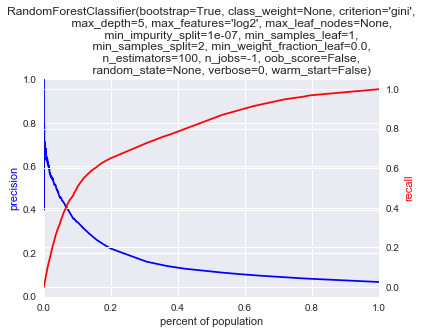

parameters
{'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 10}
generate_binary_at_k
37500
5.0
cutoff_index
1875
generate_binary_at_k
37500
10.0
cutoff_index
3750
generate_binary_at_k
37500
20.0
cutoff_index
7500


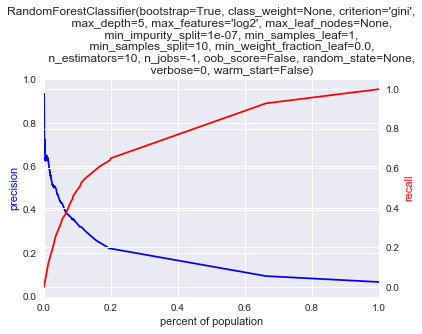

parameters
{'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 100}
generate_binary_at_k
37500
5.0
cutoff_index
1875
generate_binary_at_k
37500
10.0
cutoff_index
3750
generate_binary_at_k
37500
20.0
cutoff_index
7500


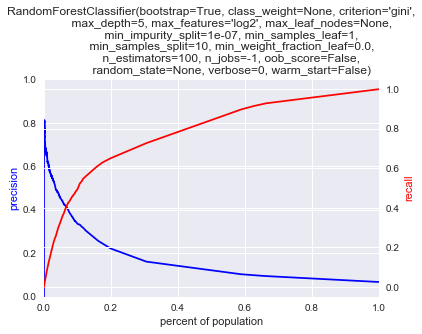

parameters
{'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 10}
generate_binary_at_k
37500
5.0
cutoff_index
1875
generate_binary_at_k
37500
10.0
cutoff_index
3750
generate_binary_at_k
37500
20.0
cutoff_index
7500


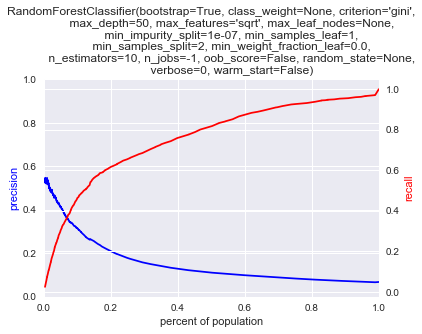

parameters
{'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}
generate_binary_at_k
37500
5.0
cutoff_index
1875
generate_binary_at_k
37500
10.0
cutoff_index
3750
generate_binary_at_k
37500
20.0
cutoff_index
7500


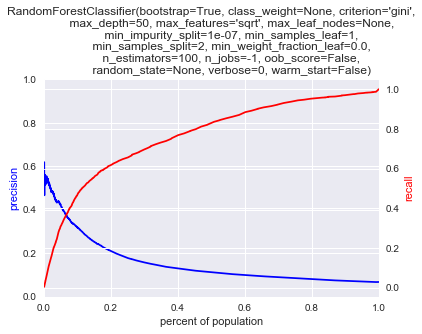

parameters
{'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 10}
generate_binary_at_k
37500
5.0
cutoff_index
1875
generate_binary_at_k
37500
10.0
cutoff_index
3750
generate_binary_at_k
37500
20.0
cutoff_index
7500


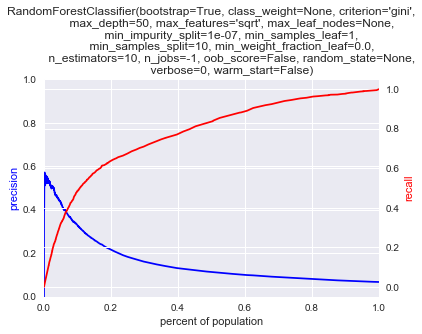

parameters
{'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100}
generate_binary_at_k
37500
5.0
cutoff_index
1875
generate_binary_at_k
37500
10.0
cutoff_index
3750
generate_binary_at_k
37500
20.0
cutoff_index
7500


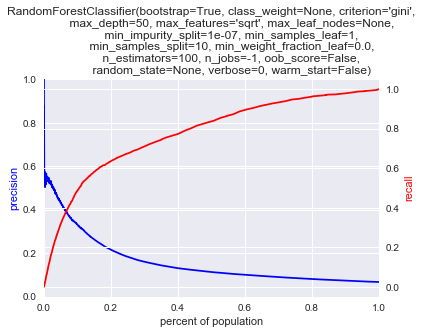

parameters
{'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 10}
generate_binary_at_k
37500
5.0
cutoff_index
1875
generate_binary_at_k
37500
10.0
cutoff_index
3750
generate_binary_at_k
37500
20.0
cutoff_index
7500


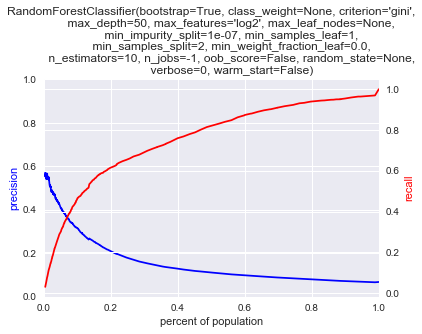

parameters
{'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100}
generate_binary_at_k
37500
5.0
cutoff_index
1875
generate_binary_at_k
37500
10.0
cutoff_index
3750
generate_binary_at_k
37500
20.0
cutoff_index
7500


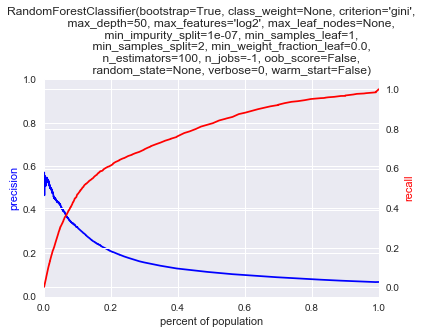

parameters
{'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 10}
generate_binary_at_k
37500
5.0
cutoff_index
1875
generate_binary_at_k
37500
10.0
cutoff_index
3750
generate_binary_at_k
37500
20.0
cutoff_index
7500


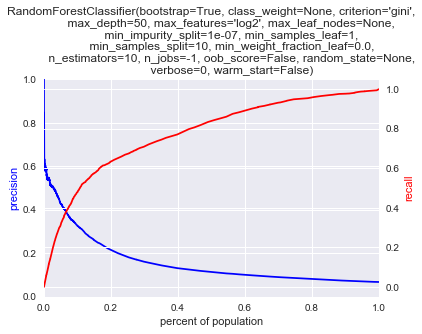

parameters
{'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 100}
generate_binary_at_k
37500
5.0
cutoff_index
1875
generate_binary_at_k
37500
10.0
cutoff_index
3750
generate_binary_at_k
37500
20.0
cutoff_index
7500


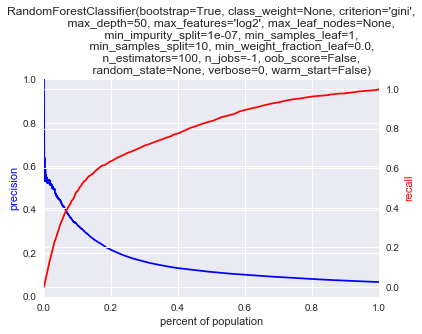

clf
AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=200, random_state=None)
parameters
{'algorithm': 'SAMME', 'n_estimators': 1}
generate_binary_at_k
37500
5.0
cutoff_index
1875
generate_binary_at_k
37500
10.0
cutoff_index
3750
generate_binary_at_k
37500
20.0
cutoff_index
7500


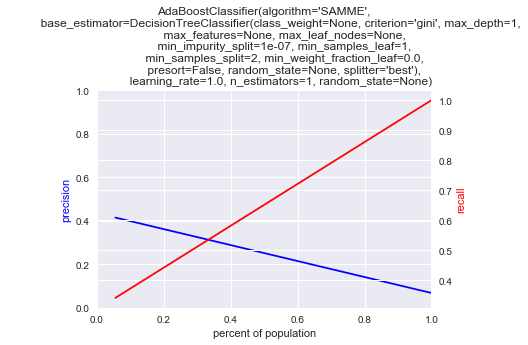

parameters
{'algorithm': 'SAMME', 'n_estimators': 10}
generate_binary_at_k
37500
5.0
cutoff_index
1875
generate_binary_at_k
37500
10.0
cutoff_index
3750
generate_binary_at_k
37500
20.0
cutoff_index
7500


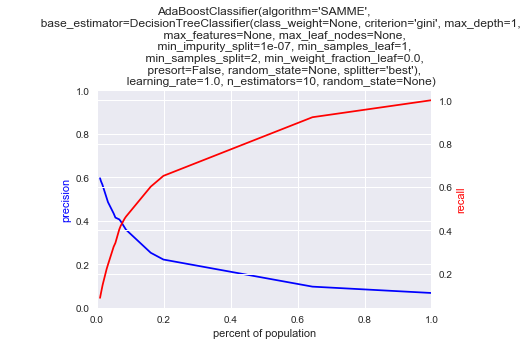

parameters
{'algorithm': 'SAMME', 'n_estimators': 100}
generate_binary_at_k
37500
5.0
cutoff_index
1875
generate_binary_at_k
37500
10.0
cutoff_index
3750
generate_binary_at_k
37500
20.0
cutoff_index
7500


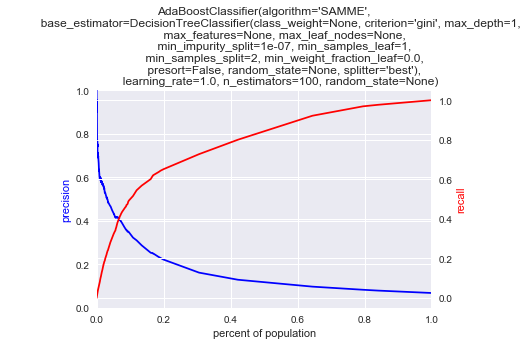

parameters
{'algorithm': 'SAMME', 'n_estimators': 1000}
generate_binary_at_k
37500
5.0
cutoff_index
1875
generate_binary_at_k
37500
10.0
cutoff_index
3750
generate_binary_at_k
37500
20.0
cutoff_index
7500


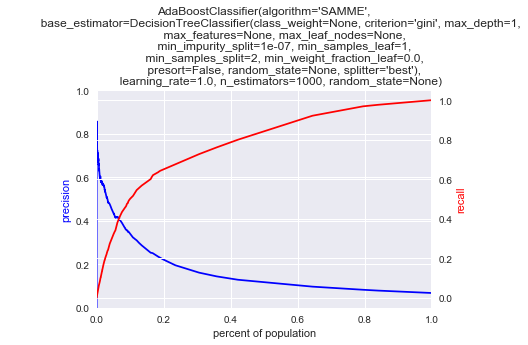

parameters
{'algorithm': 'SAMME', 'n_estimators': 10000}
generate_binary_at_k
37500
5.0
cutoff_index
1875
generate_binary_at_k
37500
10.0
cutoff_index
3750
generate_binary_at_k
37500
20.0
cutoff_index
7500


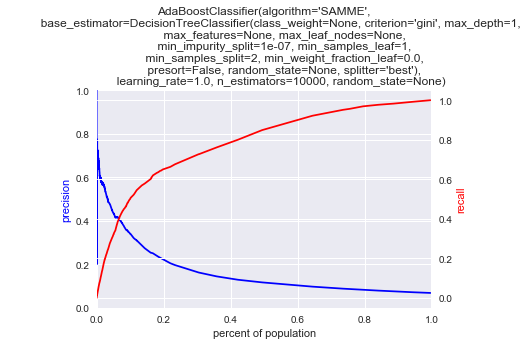

parameters
{'algorithm': 'SAMME.R', 'n_estimators': 1}
generate_binary_at_k
37500
5.0
cutoff_index
1875
generate_binary_at_k
37500
10.0
cutoff_index
3750
generate_binary_at_k
37500
20.0
cutoff_index
7500


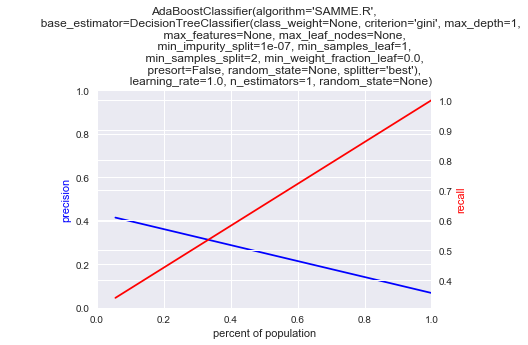

parameters
{'algorithm': 'SAMME.R', 'n_estimators': 10}
generate_binary_at_k
37500
5.0
cutoff_index
1875
generate_binary_at_k
37500
10.0
cutoff_index
3750
generate_binary_at_k
37500
20.0
cutoff_index
7500


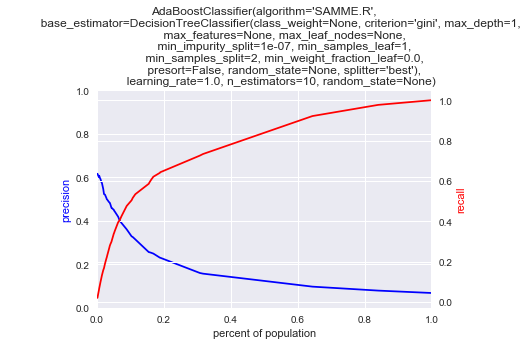

parameters
{'algorithm': 'SAMME.R', 'n_estimators': 100}
generate_binary_at_k
37500
5.0
cutoff_index
1875
generate_binary_at_k
37500
10.0
cutoff_index
3750
generate_binary_at_k
37500
20.0
cutoff_index
7500


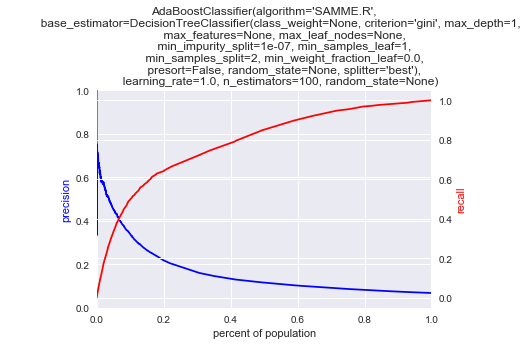

parameters
{'algorithm': 'SAMME.R', 'n_estimators': 1000}
generate_binary_at_k
37500
5.0
cutoff_index
1875
generate_binary_at_k
37500
10.0
cutoff_index
3750
generate_binary_at_k
37500
20.0
cutoff_index
7500


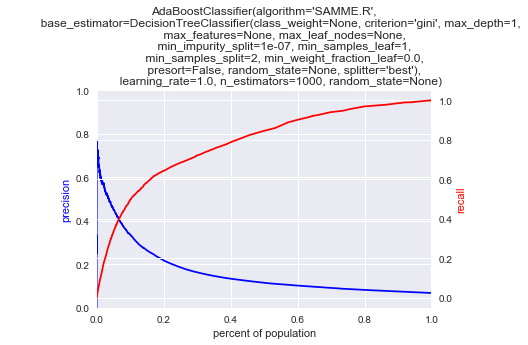

parameters
{'algorithm': 'SAMME.R', 'n_estimators': 10000}
generate_binary_at_k
37500
5.0
cutoff_index
1875
generate_binary_at_k
37500
10.0
cutoff_index
3750
generate_binary_at_k
37500
20.0
cutoff_index
7500


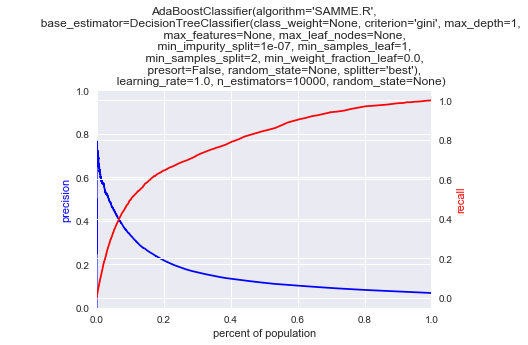

clf
LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
parameters
{'C': 1e-05, 'penalty': 'l1'}
generate_binary_at_k
37500
5.0
cutoff_index
1875
generate_binary_at_k
37500
10.0
cutoff_index
3750
generate_binary_at_k
37500
20.0
cutoff_index
7500


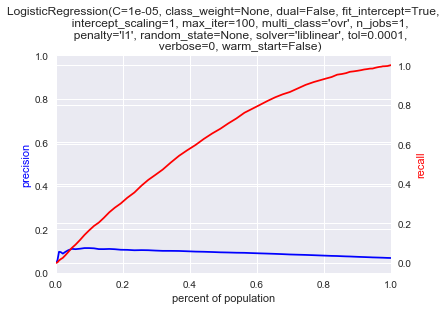

parameters
{'C': 1e-05, 'penalty': 'l2'}
generate_binary_at_k
37500
5.0
cutoff_index
1875
generate_binary_at_k
37500
10.0
cutoff_index
3750
generate_binary_at_k
37500
20.0
cutoff_index
7500


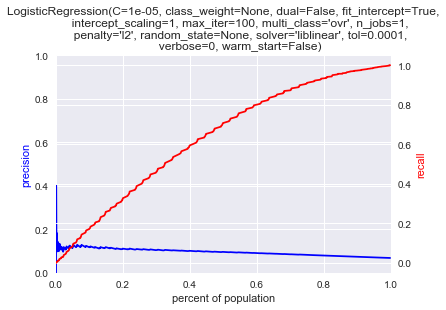

parameters
{'C': 0.001, 'penalty': 'l1'}
generate_binary_at_k
37500
5.0
cutoff_index
1875
generate_binary_at_k
37500
10.0
cutoff_index
3750
generate_binary_at_k
37500
20.0
cutoff_index
7500


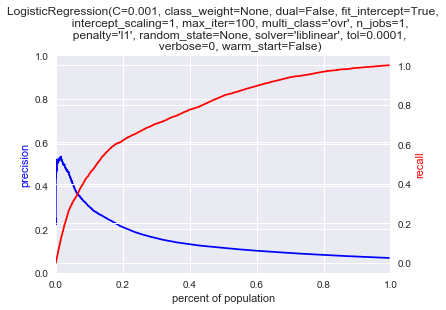

parameters
{'C': 0.001, 'penalty': 'l2'}
generate_binary_at_k
37500
5.0
cutoff_index
1875
generate_binary_at_k
37500
10.0
cutoff_index
3750
generate_binary_at_k
37500
20.0
cutoff_index
7500


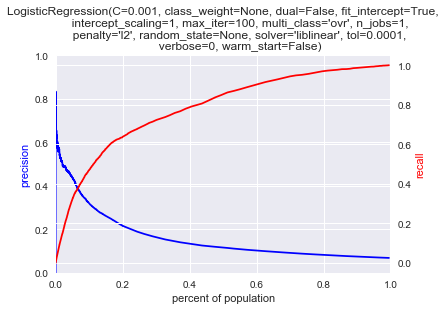

parameters
{'C': 0.1, 'penalty': 'l1'}
generate_binary_at_k
37500
5.0
cutoff_index
1875
generate_binary_at_k
37500
10.0
cutoff_index
3750
generate_binary_at_k
37500
20.0
cutoff_index
7500


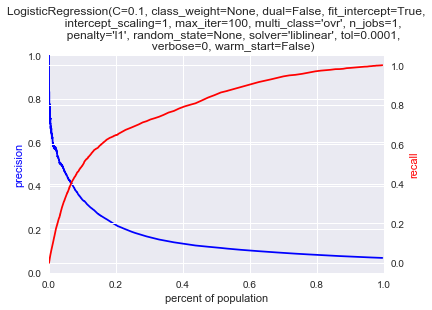

parameters
{'C': 0.1, 'penalty': 'l2'}
generate_binary_at_k
37500
5.0
cutoff_index
1875
generate_binary_at_k
37500
10.0
cutoff_index
3750
generate_binary_at_k
37500
20.0
cutoff_index
7500


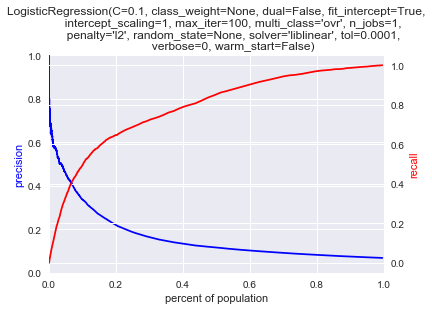

parameters
{'C': 1, 'penalty': 'l1'}
generate_binary_at_k
37500
5.0
cutoff_index
1875
generate_binary_at_k
37500
10.0
cutoff_index
3750
generate_binary_at_k
37500
20.0
cutoff_index
7500


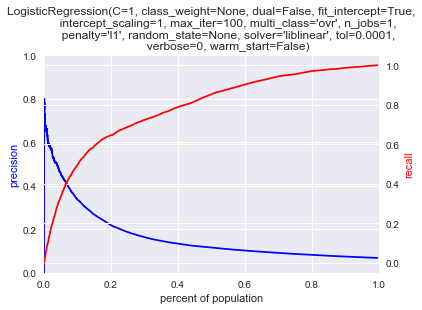

parameters
{'C': 1, 'penalty': 'l2'}
generate_binary_at_k
37500
5.0
cutoff_index
1875
generate_binary_at_k
37500
10.0
cutoff_index
3750
generate_binary_at_k
37500
20.0
cutoff_index
7500


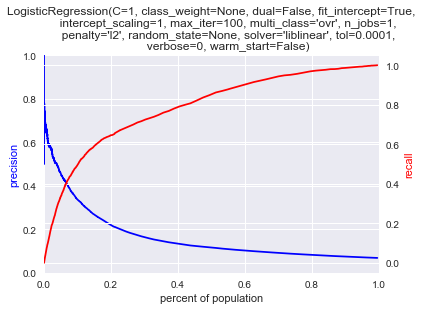

parameters
{'C': 10, 'penalty': 'l1'}
generate_binary_at_k
37500
5.0
cutoff_index
1875
generate_binary_at_k
37500
10.0
cutoff_index
3750
generate_binary_at_k
37500
20.0
cutoff_index
7500


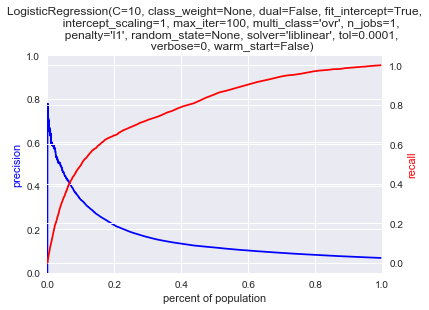

parameters
{'C': 10, 'penalty': 'l2'}
generate_binary_at_k
37500
5.0
cutoff_index
1875
generate_binary_at_k
37500
10.0
cutoff_index
3750
generate_binary_at_k
37500
20.0
cutoff_index
7500


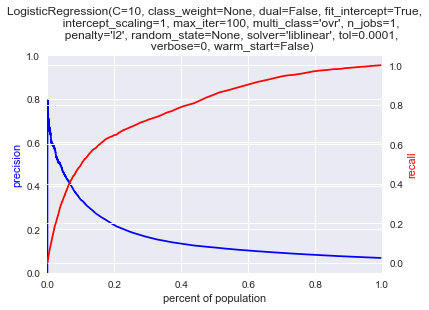

clf
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
  verbose=False)
parameters
{'C': 1e-05, 'kernel': 'linear'}
generate_binary_at_k
37500
5.0
cutoff_index
1875
generate_binary_at_k
37500
10.0
cutoff_index
3750
generate_binary_at_k
37500
20.0
cutoff_index
7500


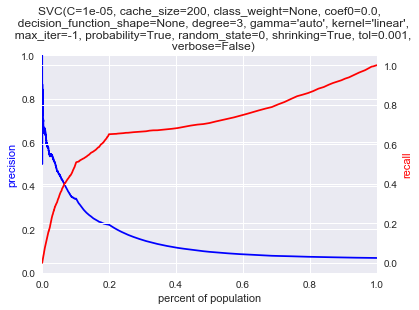

parameters
{'C': 0.0001, 'kernel': 'linear'}


In [ ]:
results_df = results(X,y)

In [ ]:
print(results_df)

## 6) Evaluate Classifier

### Baseline estimation 

In [138]:
y.mean()


0.06684

In [139]:
1-0.06684

0.93316

Which would be the accuracy of a "naive" model? For example, predicting just SeriousDlqin2yrs == 0? With that model, we would reach  $93.31$ percent of accuracy (there is a very low prevalence of "financial distress" in the sample). Therefore, our model has to predict with more than 93.31 percent of accuracy in order to beat that baseline estimation.

## Conclusion

In this exercise, we did some descriptive statistics about the age and income levels of the persons that suffered financial distress and those that didn't. Also, applying simple functions, we processed the dataset (fill missing values, categorize variables and so on). Additionaly, we ran a logistic regresion model to predict financial distress and compared some accuracy metrics between our predictions and the predictions of a "naive" baseline model. Finally, our model did a slightly better job that the baseline (by $0.34$ percent).


Thank you for your time.

Pedro Armengol